In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
y_train[4572]

6

In [4]:
X = np.concatenate((x_train, x_test))
Y = np.concatenate((y_train, y_test))

In [8]:
l = []
for i in range(5):
    l.append([])
    for img in X:
        l[i].append(rotate(img,10*i, reshape = False))

In [9]:
train = []
test = []

for item in l:
    train.append(item[0:60000])
    test.append(item[60000:])

In [10]:
len(test[0])

10000

In [11]:
Xtrain = []
for i in train:
    Xtrain.append(np.array(i).reshape(60000,784))

In [12]:
Xtrain[4].shape

(60000, 784)

In [13]:
Xtest = []
for i in test:
    Xtest.append(np.array(i).reshape(10000,784))

In [14]:
Xtest[4].shape

(10000, 784)

In [15]:
X_train = Xtrain
X_test = Xtest

In [16]:
len(X_train)

5

In [17]:
#one hot encoding
Y_train = np.eye(10)[y_train]
Y_test = np.eye(10)[y_test]

In [18]:
n_hidden_1 = 256
n_hidden_2 = 256
n_input = 784
n_classes = 10


In [19]:
tf.compat.v1.disable_eager_execution()

In [20]:
x = tf.compat.v1.placeholder(tf.float32, [None, 784])
y_ = tf.compat.v1.placeholder(tf.float32, [None, 10])
keep_prob = tf.compat.v1.placeholder(tf.float32)
rate = tf.compat.v1.placeholder_with_default(0.0, shape=())

In [21]:
batch_size = 64
learning_rate = 0.01
momentum = 0.8

In [22]:
# https://arxiv.org/pdf/1707.09725.pdf#page=95
# for relu lates
# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni). 
# h1 =>  σ=√(2/(fan_in+1) = 0.062  => N(0,σ) = N(0,0.062)
# h2 =>  σ=√(2/(fan_in+1) = 0.125  => N(0,σ) = N(0,0.125)
# out =>  σ=√(2/(fan_in+1) = 0.120  => N(0,σ) = N(0,0.120)
# He Normal initialization.
weights = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1],stddev=0.062, mean=0)),    #784x512
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2],stddev=0.125, mean=0)), #512x128
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_classes],stddev=0.120, mean=0))  #128x10
}

biases = {
    'b1': tf.compat.v1.Variable(tf.random.normal([n_hidden_1])),             #512x1
    'b2': tf.compat.v1.Variable(tf.random.normal([n_hidden_2])),             #128x1
    'out': tf.compat.v1.Variable(tf.random.normal([n_classes]))              #10x1
}

In [23]:
# Parameters
training_epochs = 5
batch_size = 64
display_step = 1
ntasks = 5

In [24]:
def generate_batches(x,y,batch_size = 32):
    assert x.shape[0]==y.shape[0],\
    '''
    features and target must have same number of rows, instead features has {0} and target has {1}.
    '''.format(X.shape[0],y.shape[0])
    
    n = x.shape[0]
    
    for i in range(0,n,batch_size):
        yield x[i:i+batch_size],y[i:i+batch_size]
    

In [25]:
def initialize_lists(*lists,value = []):
    for l in lists:
        l.append(value)

In [26]:
def mlp(x, weights, biases):
    
    print('Input Layer: ', x.shape, 'W[h1]: ', weights['h1'].shape, 'b[h1]: ', biases['b1'].shape )
    
    # Hidden Layer 1 with ReLU and Dropout
    layer1 = tf.add( tf.matmul(x,weights['h1']),biases['b1'])
    layer1 = tf.nn.relu(layer1)
    
    print('Hidden Layer 1: ', layer1.shape, 'W[h2]: ', weights['h2'].shape, 'b[h2]: ', biases['b2'].shape )
    
    # Hidden Layer 2 with ReLU activation and Dropout
    layer2 = tf.add(tf.matmul(layer1, weights['h2']), biases['b2'])
    layer2 = tf.nn.relu(layer2)
    
    print('Hidden Layer 2: ', layer2.shape, 'W[out]:', weights['out'].shape, 'b[out]:',biases['out'].shape)
    
    # OUtput Layer
    output_layer = tf.add(tf.matmul(layer2, weights['out']), biases['out'])
    output_layer = tf.nn.sigmoid(output_layer)
    print('Output Layer: ', output_layer.shape)
    
    return output_layer 

In [27]:
y = mlp(x, weights, biases)

Input Layer:  (None, 784) W[h1]:  (784, 256) b[h1]:  (256,)
Hidden Layer 1:  (None, 256) W[h2]:  (256, 256) b[h2]:  (256,)
Hidden Layer 2:  (None, 256) W[out]: (256, 10) b[out]: (10,)
Output Layer:  (None, 10)


In [28]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y, labels=y_ ))

In [29]:
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.001
learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate,global_step,4650, 0.8)#, staircase=True)

In [30]:
optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.8).minimize(cost, global_step=global_step)

***************Task 1 begins******************
*******************EPOCH 1***********************

Epoch: 0001 train cost=1.822046558 test cost=1.808985298
Accuracy for task 1 epoch 1 = 0.7940999865531921 

*******************EPOCH 2***********************

Epoch: 0002 train cost=1.646276583 test cost=1.638540134
Accuracy for task 1 epoch 2 = 0.855400025844574 

*******************EPOCH 3***********************

Epoch: 0003 train cost=1.610479582 test cost=1.602889872
Accuracy for task 1 epoch 3 = 0.8751999735832214 

*******************EPOCH 4***********************

Epoch: 0004 train cost=1.590491380 test cost=1.583205647
Accuracy for task 1 epoch 4 = 0.8880000114440918 

*******************EPOCH 5***********************

Epoch: 0005 train cost=1.579490904 test cost=1.575253935
Accuracy for task 1 epoch 5 = 0.8824999928474426 

***************Task 2 begins******************
*******************EPOCH 1***********************

Epoch: 0001 train cost=1.587838202 test cost=1.582969918
Accu

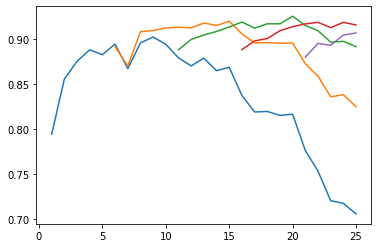

In [31]:
with tf.compat.v1.Session() as sess:
    tf.compat.v1.global_variables_initializer().run()
    accuracy_list = []
    steps = 0
    #learning_rate = 0.01
    for task in range(ntasks):
        accuracy_list.append([])
        print('***************Task {} begins******************'.format(task+1))
        #learning_rate *=0.8
        #optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.8).minimize(cost)
        #tf.compat.v1.global_variables_initializer().run()
        for epoch in range(5):
            train_avg_cost = 0
            test_avg_cost = 0
            nbatches = int(X_train[task].shape[0]/batch_size)
            
            for i, (Xbatch, Ybatch) in enumerate(generate_batches(X_train[task], Y_train, batch_size = 64)):
                _,c,w = sess.run([optimizer, cost, weights], feed_dict = {x: Xbatch, y_: Ybatch})
                train_avg_cost += c/nbatches
                c = sess.run(cost, feed_dict={x: X_test[task], y_: Y_test})
                test_avg_cost += c/nbatches
                #steps = steps + 1
            #print('step epoch {} task {} = {}'.format(epoch,task,steps))    
            correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
            print('*******************EPOCH {}***********************\n'.format(epoch+1))
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
            for i in range(task+1):
                accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32)).eval({x: X_test[i], y_: Y_test})
                accuracy_list[i].append(accuracy)
                print('Accuracy for task {} epoch {} = {} \n'.format(i+1,epoch+1, accuracy))
    total_epochs = len(accuracy_list[0])
    plt.plot(list(range(1,total_epochs+1)),accuracy_list[0], label = 'task 1')
    plt.plot(list(range(6,total_epochs+1)),accuracy_list[1], label = 'task 2')
    plt.plot(list(range(11,total_epochs+1)),accuracy_list[2], label = 'task 3')
    plt.plot(list(range(16,total_epochs+1)),accuracy_list[3], label = 'task 4')
    plt.plot(list(range(21,total_epochs+1)),accuracy_list[4], label = 'task 5')
    plt.show()
            


In [32]:
accuracy_sgd = accuracy_list

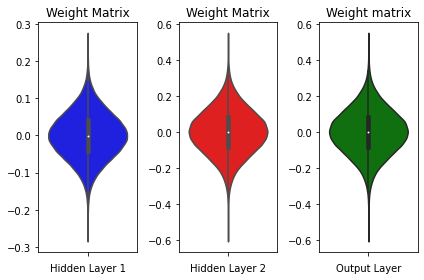

In [106]:
w_h1 = w['h1'].flatten()[:,np.newaxis]
w_h2 = w['h2'].flatten()[:,np.newaxis]
w_out = w['out'].flatten()[:,np.newaxis]

fig = plt.figure()

plt.subplot(131)
plt.title('Weight Matrix')
ax = sns.violinplot(y=w_h1,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(132)
plt.title('Weight Matrix')
ax = sns.violinplot(y=w_h2, color='r')
plt.xlabel('Hidden Layer 2')

plt.subplot(133)
plt.title('Weight matrix')
ax = sns.violinplot(y=w_h2, color='g')
plt.xlabel('Output Layer')

plt.tight_layout()

In [107]:
def mlp_dropout(x, weights, biases):
    
    print('Input Layer: ', x.shape, 'W[h1]: ', weights['h1'].shape, 'b[h1]: ', biases['b1'].shape )
    
    # Hidden Layer 1 woth ReLU and Dropout
    layer1 = tf.add( tf.matmul(x,weights['h1']),biases['b1'])
    layer1 = tf.compat.v1.nn.relu(layer1)
    layer1_dropout = tf.compat.v1.nn.dropout(layer1, rate=rate)
    
    print('Hidden Layer 1: ', layer1.shape, 'W[h2]: ', weights['h2'].shape, 'b[h2]: ', biases['b2'].shape )
    
    # Hidden Layer 2 with ReLU activation and Dropout
    layer2 = tf.add(tf.matmul(layer1_dropout, weights['h2']), biases['b2'])
    layer2 = tf.compat.v1.nn.relu(layer2)
    layer2_dropout = tf.compat.v1.nn.dropout(layer2,rate=rate)
    
    print('Hidden Layer 2: ', layer2.shape, 'W[out]:', weights['out'].shape, 'b[out]:',biases['out'].shape)
    
    # OUtput Layer
    output_layer = tf.add(tf.matmul(layer2_dropout, weights['out']), biases['out'])
    output_layer = tf.compat.v1.nn.sigmoid(output_layer)
    print('Output Layer: ', output_layer.shape)
    
    return output_layer 

In [108]:
ydrop = mlp_dropout(x, weights, biases)

Input Layer:  (None, 784) W[h1]:  (784, 256) b[h1]:  (256,)
Hidden Layer 1:  (None, 256) W[h2]:  (256, 256) b[h2]:  (256,)
Hidden Layer 2:  (None, 256) W[out]: (256, 10) b[out]: (10,)
Output Layer:  (None, 10)


In [109]:
cost_dropout = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ydrop, labels=y_ ))

In [110]:
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.001
learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate,global_step,4650, 0.8)#, staircase=True)

In [111]:
optimizer_dropout = tf.compat.v1.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.8).minimize(cost_dropout,global_step=global_step)

***************Task 1 begins******************
*******************EPOCH 1***********************

Epoch: 0001 train cost=2.272753633 test cost=2.205174767
Accuracy for task 1 epoch 1 = 0.5358999967575073 

*******************EPOCH 2***********************

Epoch: 0002 train cost=2.076366359 test cost=1.928819668
Accuracy for task 1 epoch 2 = 0.5976999998092651 

*******************EPOCH 3***********************

Epoch: 0003 train cost=1.967900619 test cost=1.775511788
Accuracy for task 1 epoch 3 = 0.7214999794960022 

*******************EPOCH 4***********************

Epoch: 0004 train cost=1.893891229 test cost=1.715649436
Accuracy for task 1 epoch 4 = 0.7718999981880188 

*******************EPOCH 5***********************

Epoch: 0005 train cost=1.857600556 test cost=1.703023012
Accuracy for task 1 epoch 5 = 0.7856000065803528 

***************Task 2 begins******************
*******************EPOCH 1***********************

Epoch: 0001 train cost=1.842518049 test cost=1.704492867
Acc

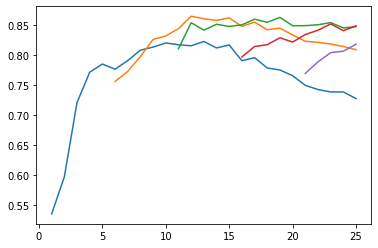

In [112]:
with tf.compat.v1.Session() as sess:
    tf.compat.v1.global_variables_initializer().run()
    accuracy_list = []
    for task in range(ntasks):
        accuracy_list.append([])
        print('***************Task {} begins******************'.format(task+1))
        #learning_rate *=0.8
        #optimizer_dropout = tf.compat.v1.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.8).minimize(cost_dropout)
        #tf.compat.v1.global_variables_initializer().run()
        for epoch in range(training_epochs):
            train_avg_cost = 0
            test_avg_cost = 0
            nbatches = int(X_train[task].shape[0]/batch_size)
            
            for i, (Xbatch, Ybatch) in enumerate(generate_batches(X_train[task], Y_train, batch_size = 64)):
                _,c,w = sess.run([optimizer_dropout, cost_dropout, weights], feed_dict = {x: Xbatch, y_: Ybatch, rate : 0.5})
                train_avg_cost += c/nbatches
                c = sess.run(cost_dropout, feed_dict={x: X_test[task], y_: Y_test, rate:0.0})
                test_avg_cost += c/nbatches
            correct_prediction = tf.equal(tf.argmax(ydrop,1),tf.argmax(y_,1))
            print('*******************EPOCH {}***********************\n'.format(epoch+1))
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
            for i in range(task+1):
                accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32)).eval({x: X_test[i], y_: Y_test, rate: 0.0})
                accuracy_list[i].append(accuracy)
                print('Accuracy for task {} epoch {} = {} \n'.format(i+1,epoch+1, accuracy))
    total_epochs = len(accuracy_list[0])
    plt.plot(list(range(1,total_epochs+1)),accuracy_list[0], label = 'task 1')
    plt.plot(list(range(6,total_epochs+1)),accuracy_list[1], label = 'task 2')
    plt.plot(list(range(11,total_epochs+1)),accuracy_list[2], label = 'task 3')
    plt.plot(list(range(16,total_epochs+1)),accuracy_list[3], label = 'task 4')
    plt.plot(list(range(21,total_epochs+1)),accuracy_list[4], label = 'task 5')
    plt.show()
            